---

In [3]:
import pybullet as p
import numpy as np
import tensorflow as tf

from pybullet_robot import PyBulletRobot, W, H

import sys, glob, time
import pandas as pd 
import collections

from IPython.display import clear_output
from matplotlib import pyplot as plt

%matplotlib inline

In [4]:
def mk_model(L):
    inputs = tf.keras.Input(shape=(9,))
    
    layer = tf.keras.layers.Dense(64, activation='relu')(inputs)
    for _ in range(L):
        layer = tf.keras.layers.Dense(64, activation='relu')(layer)
    outputs = tf.keras.layers.Dense(8, activation='tanh')(layer)

    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

#print(model.summary())

In [10]:
def mk_xy(M):
    X = np.zeros((M, 9))
    Y = np.zeros((M, 8))

    Y[:,0] = np.random.uniform(low=-0.6, high=0, size=(M))
    Y[:,2] = np.random.uniform(low=0.3, high=0.8, size=(M))
    Y[:,4] = Y[:,6] = np.random.uniform(low=0.3, high=0.8, size=(M))

    Y[:,1] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,3] = np.random.uniform(low=-0.6, high=0.6, size=(M))
    Y[:,5] = Y[:,7] = np.random.uniform(low=-0.6, high=0.6, size=(M))

    for i in range(M):
        phis = Y[i,:].reshape(-1, 2)
        r.step(phis)
        cam_p, cam_v, cam_u = r.getHeadcamPVU()
        X[i] = list(cam_p) + list(cam_v) + list(cam_u)
    
    return X, Y

In [6]:
def plot_fh(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [7]:
def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [12]:
def get_headcam_pvu(alpha, beta):
    # inclination θ, azimuth φ
    theta = np.pi/2 - beta
    phi = alpha
    cam_vx = np.sin(theta) * np.cos(phi)
    cam_vy = np.sin(theta) * np.sin(phi)
    cam_vz = np.cos(theta)
       
    theta = -beta
    phi = alpha
    cam_ux = np.sin(theta) * np.cos(phi)
    cam_uy = np.sin(theta) * np.sin(phi)
    cam_uz = np.cos(theta)
    
    cam_v = [cam_vx, cam_vy, cam_vz]
    cam_u = [cam_ux, cam_uy, cam_uz]
    cam_p = [0.23, 0.0, 0.67]
    
    return cam_p, cam_v, cam_u

def set_robot_pose(alpha, beta):
    cam_p, cam_v, cam_u = get_headcam_pvu(alpha, beta)

    test_X = np.array([cam_p + cam_v + cam_u], dtype=np.float32)
    pred_phis = model.predict(test_X)
    r.step(pred_phis.reshape(-1,2))
    pvu = r.getHeadcamPVU()

    r.getCameraImage()
    return [cam_p, cam_v, cam_u], pvu, pred_phis.reshape(-1)

In [8]:
########################################

In [9]:
gui = True
r = PyBulletRobot(4, 1, render=gui)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [11]:
X, Y = mk_xy(500000)
print("Shape of X=%s and Y=%s" % (X.shape, Y.shape))

Shape of X=(500000, 9) and Y=(500000, 8)


In [13]:
MAX_ALPHA = np.pi/4
D_ALPHA = 0.025

alpha = -MAX_ALPHA
dalpha = D_ALPHA

def eval_model(model):
    data = collections.defaultdict(list)

    for alpha in np.arange(-MAX_ALPHA, MAX_ALPHA+D_ALPHA, D_ALPHA):
        pvu0, pvu1, phis = set_robot_pose(alpha, 0)

        if False:
            data['cam_vx0'].append(pvu0[1][0])
            data['cam_vx1'].append(pvu1[1][0])
            data['cam_vy0'].append(pvu0[1][1])
            data['cam_vy1'].append(pvu1[1][1])
            data['cam_vz0'].append(pvu0[1][2])
            data['cam_vz1'].append(pvu1[1][2])

        if True:
            data['cam_ux0'].append(pvu0[2][0])
            data['cam_ux1'].append(pvu1[2][0])
            data['cam_uy0'].append(pvu0[2][1])
            data['cam_uy1'].append(pvu1[2][1])
            data['cam_uz0'].append(pvu0[2][2])
            data['cam_uz1'].append(pvu1[2][2])

        if False:
            for i in range(phis.shape[0]):
                data['phi%d' % i].append(phis[i])

        live_plot(data)
    return data

In [17]:
hs = dict()

for L in range(1, 5):
    print("*** L=%d" % (L))
    
    model = mk_model(L)
    h = model.fit(X, Y, batch_size=256, epochs=10, shuffle=True, validation_split=0.002)
    
    hs[L] = h
    model.save('pose2phis-%d' % L)

*** L=1
Train on 499000 samples, validate on 1000 samples
Epoch 1/10
499000/499000 [==============================] - 4s 8us/sample - loss: 0.0164 - mean_absolute_error: 0.0857 - val_loss: 0.0109 - val_mean_absolute_error: 0.0677
Epoch 2/10
499000/499000 [==============================] - 4s 8us/sample - loss: 0.0093 - mean_absolute_error: 0.0603 - val_loss: 0.0078 - val_mean_absolute_error: 0.0542
Epoch 3/10
499000/499000 [==============================] - 4s 8us/sample - loss: 0.0075 - mean_absolute_error: 0.0525 - val_loss: 0.0067 - val_mean_absolute_error: 0.0499
Epoch 4/10
499000/499000 [==============================] - 4s 8us/sample - loss: 0.0067 - mean_absolute_error: 0.0490 - val_loss: 0.0061 - val_mean_absolute_error: 0.0469
Epoch 5/10
499000/499000 [==============================] - 4s 8us/sample - loss: 0.0062 - mean_absolute_error: 0.0465 - val_loss: 0.0057 - val_mean_absolute_error: 0.0445
Epoch 6/10
499000/499000 [==============================] - 4s 8us/sample - loss: 

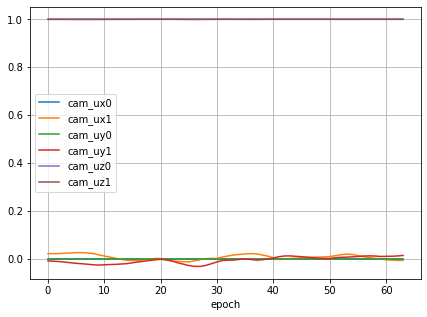

In [19]:
for L in range(1, 5):
    print("*** L=%d" % (L))
    model = tf.keras.models.load_model('pose2phis-%d' % L)
    eval_model(model)